In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# reading original image
original_img=cv2.imread('brick.png')

#converting image to grayscale
try:
    row, col, ch = original_img.shape
    original_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)   
except:
    print('Image already grayscale')

Image already grayscale


In [3]:
#reading noisy image
img=cv2.imread('brick_noisy.png')

#converting image to grayscale
try:
    row, col, ch = img.shape
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)   
except:
    print('Image already grayscale')

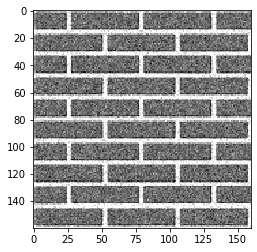

In [4]:
plt.imshow(img, cmap='gray')

## Nl-means

In [5]:
nl_img = cv2.fastNlMeansDenoising(img, 10, 24, 80)

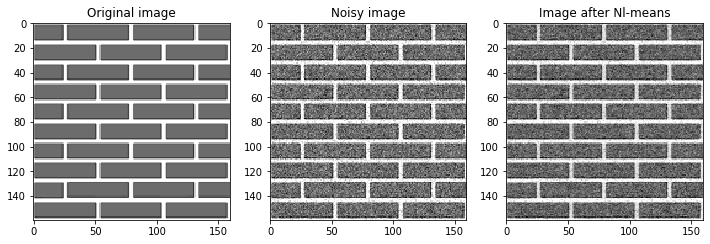

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(12,12))

ax[0].imshow(original_img, cmap='gray')
ax[1].imshow(img, cmap='gray')
ax[2].imshow(nl_img, cmap='gray')

ax[0].title.set_text('Original image')
ax[1].title.set_text('Noisy image')
ax[2].title.set_text('Image after Nl-means')

## Total variation minimization

In a <b>total variation minimization</b>, the task is to minimize the cost_function defined as:<br>
<center><i>cost_function = norm(current_img - original_img) + lambda*regularization term</i></center>
The first expression in the cost_function ensures that the modified image remains similar to the original image. The regularization term is selected as per the need (for instance, whether image needs to be smoothened, or if the edges needs to be preserved.)
<br><br>
Two different regularization terms are tried out:
<ul>
    <li>cost_func1 (= gradient of image^2): Minimize the change of intensity in image. It smoothens the image</li>
    <li>cost_func2 (= square root(1 + (gradient^2)/(delta^2)) - 1): Huber Penalty. When gradient is very large(near edges), function is linear in gradient. For small value of gradient(smooth region), function is quadratic in gradient. Hence, it preserves edges along with smoothening.</li>
</ul>

In [7]:
def cost_func1(img, noisy_img, LAMBDA):

    G= np.resize(img, noisy_img.shape)
    diff= np.subtract(G, noisy_img)
    GRAD= np.gradient(G)
    cost= np.sum(np.square(diff)) + LAMBDA * (np.sum(np.square(GRAD[0])) + np.sum(np.square(GRAD[1])))
    return cost

def derivative1(img, noisy_img, LAMBDA):
    G= np.resize(img, noisy_img.shape)
    double_grad= np.add(np.gradient(np.gradient(G, axis=0), axis=0), np.gradient(np.gradient(G, axis=1), axis=1))  
    der= 2* np.subtract(np.subtract(G, noisy_img), LAMBDA * double_grad)
    return der

In [8]:
def cost_func2(g, g0, LAMBDA):
    
    delta=np.median(np.gradient(g0))
    
    diff= np.subtract(g, g0)
    GRAD= np.gradient(g)
    GRAD_SQUARED= np.square(GRAD[0]) + np.square(GRAD[1])
    
    penalty= np.sum(np.sqrt(1+ (1/(delta**2))* GRAD_SQUARED) - 1)
    cost= np.sum(np.square(diff)) + LAMBDA * penalty
    
    return cost

def derivative2(g, g0, LAMBDA):
    
    delta=np.median(np.gradient(g0))
    gX=np.gradient(g, axis=0)
    gY=np.gradient(g, axis=1)
    
    denom= np.sqrt(np.square(gX) + np.square(gY) + delta*delta)
    
    penalty= (1/delta)*np.add( np.gradient(np.divide(gX, denom), axis=0), np.gradient(np.divide(gY, denom), axis=1))
    
    
    der= np.subtract( 2*np.subtract(g, g0), LAMBDA * penalty)
    
    return der

In [9]:
def grad_descent(func, der, g0, LAMBDA, MAX_iter=20):
    '''Regular gradient descent. Pass the function to be minimised, its derivative and the initial value'''
    
    g=np.random.rand(g0.shape[0], g0.shape[1])
    step=1
    
    for iter in range(MAX_iter):
        
        for i in range(20):
            g_new= np.subtract(g, step*der(g, g0, LAMBDA))
            if func(g_new, g0, LAMBDA)<func(g, g0, LAMBDA):
                g=g_new
                break

            else :
                step=step/2

    return g

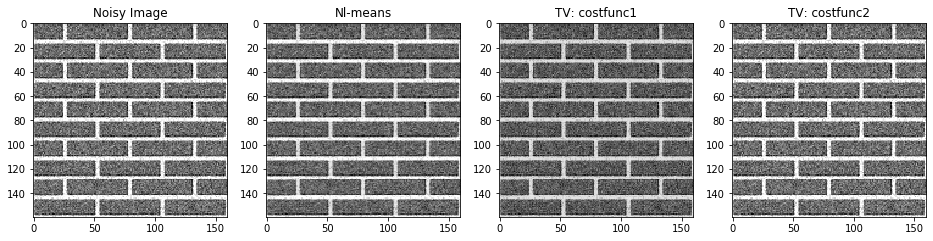

In [10]:
tv_img1=grad_descent(cost_func1, derivative1, img, 0.2)
tv_img2=grad_descent(cost_func2, derivative2, img, 20, MAX_iter=40)

fig, ax = plt.subplots(1,4, figsize=(16, 16))
ax[0].imshow(img, cmap='gray')
ax[1].imshow(nl_img, cmap='gray')
ax[2].imshow(tv_img1, cmap='gray')
ax[3].imshow(tv_img2, cmap='gray')

ax[0].title.set_text('Noisy Image')
ax[1].title.set_text('Nl-means')
ax[2].title.set_text('TV: costfunc1')
ax[3].title.set_text('TV: costfunc2')

Non-local means and total variation with costfunc1 regularization smoothens the image. They have smudged boundaries. In contrast to that, total variation with costfunc2 preserves boundaries though its denoising is poor in this case. <br>
Every case has different characteristics and differetn objectives. Which one is the best method to go with depends on the case. Hence, even though total variation with costfunc1 might not appear useful in this case, it might be a good method in some other scenerio. 